In [394]:
# from google.colab import drive
# drive.mount('/content/drive/', force_remount=True)

# from os import path

# # nazwa archiwum do dostosowania
# !unzip '/content/drive/MyDrive/archive.zip'

In [395]:
# !pip install ydata_profiling
import pandas as pd
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import numpy as np
import keras
import tensorflow as tf
import numpy as np
import imgaug.augmenters as iaa
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [396]:
class Dataset:
    def __init__(self,
                 list_attr_celeba_path="list_attr_celeba.csv",
                 list_bbox_celeba_path="list_bbox_celeba.csv",
                 list_eval_partition_path="list_eval_partition.csv",
                 list_landmarks_align_celeba_path="list_landmarks_align_celeba.csv",
                 images_path="img_align_celeba/img_align_celeba/"
                 ):

        # uncomment
        list_attr_celeba = pd.read_csv(list_attr_celeba_path)
        list_bbox_celeba = pd.read_csv(list_bbox_celeba_path)
        list_eval_partition = pd.read_csv(list_eval_partition_path)
        list_landmarks_align_celeba = pd.read_csv(list_landmarks_align_celeba_path)

        df = list_attr_celeba.merge(list_bbox_celeba, on='image_id')
        df = df.merge(list_bbox_celeba, on='image_id')
        df = df.merge(list_eval_partition, on='image_id')
        self.df = df.merge(list_landmarks_align_celeba, on='image_id')
        self.images_path = images_path

    def generate_report(self, report_name='your_report'):
        profile = ProfileReport(self.df, title="Pandas Profiling Report")
        profile.to_file(f"{report_name}.html")

    def show_some_examples(self, attribute: str, positive: bool = True):
        """
        Quick visualization of some examples

        :param attribute: One of boolean attribute:
        '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
        'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows','Chubby', 'Double_Chin', 'Eyeglasses',
        'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache',
        'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks',
        'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
        'Wearing_Necklace', 'Wearing_Necktie', 'Young'
        :type attribute: str
        :param positive: show positive examples or not (negative if false)
        :type positive: boolean
        :return: None
        :rtype: None
        """
        print(self.df.columns)
        if positive:
            exist = 1
        else:
            exist = -1

        df = self.df[self.df[attribute] == exist]
        images = list(df.head(9)['image_id'])
        images = [cv2.imread(self.images_path+path) for path in images]
        horizontal_1 = np.concatenate((images[0], images[1], images[2]), axis=1)
        horizontal_2 = np.concatenate((images[3], images[4], images[5]), axis=1)
        horizontal_3 = np.concatenate((images[6], images[7], images[8]), axis=1)
        vertical = np.concatenate((horizontal_1, horizontal_2, horizontal_3), axis=0)
        # plot first few images
        # define subplot
        plt.subplot(330 + 1 + 0)
        # plot raw pixel data
        plt.imshow(vertical)

In [397]:
class DataGenerator(tf.keras.utils.Sequence):
    """Generates data for Keras"""

    def __init__(self, images, labels, batch_size=8, shuffle=False, augment=False):
        self.labels = labels  # array of labels
        self.images = images  # array of images
        self.batch_size = batch_size  # batch size
        self.shuffle = shuffle  # shuffle bool
        self.augment = augment  # augment data bool
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.images) / self.batch_size))

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.images))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        'Generate one batch of data'
        # selects indices of data for next batch
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]

        # select data and load images
        labels = np.array([self.labels[k] for k in indexes])
        images = np.array([self.images[k] for k in indexes])

        # preprocess and augment data
        if self.augment:
            images = self.augmentor(images)

        images = images / 255
        return images, labels

    @staticmethod
    def augmentor(images):
        """Apply data augmentation"""
        def sometimes(aug):
            return iaa.Sometimes(0.5, aug)
        list_of_aumgenters = []
        list_of_aumgenters.extend([sometimes(iaa.Crop(px=(1, 16), keep_size=True)),
                                   sometimes(iaa.Fliplr(0.5)),
                                   sometimes(iaa.GaussianBlur(sigma=(0, 3.0)))])

        seq = iaa.Sequential(list_of_aumgenters)

        return seq.augment_images(images)

In [398]:
classification_dataset = Dataset() #definicja klasy Dataset

### EDA

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young', 'x_1_x', 'y_1_x', 'width_x', 'height_x',
       'x_1_y', 'y_1_y', 'width_y', 'height_y', 'partition', 'lefteye_x',
       'lefteye_y', 'righteye_x', 'righteye_y', 'nose_x', 'nose_y',
       'leftmouth_x', 'leftmouth_y', 'rightmouth_x', 'rightmouth_y'],
      dtype='object')


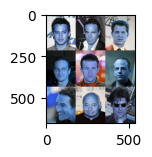

In [399]:
classification_dataset.show_some_examples('5_o_Clock_Shadow') #Podgląd kilku obrazów z tym samym atrybutem

In [400]:
item = cv2.imread('img_align_celeba/img_align_celeba/000001.jpg')

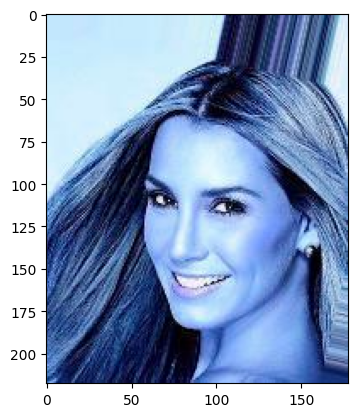

In [401]:
plt.imshow(item)

In [402]:
item.shape

(218, 178, 3)

In [403]:
list_attr_celeba = pd.read_csv('list_attr_celeba.csv')

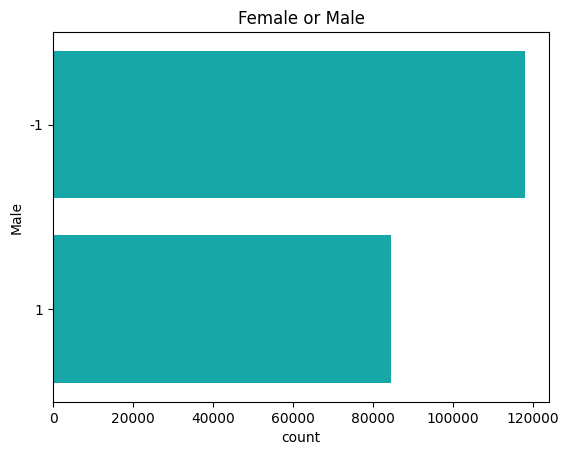

In [404]:
plt.title('Female or Male')
sns.countplot(y='Male', data=list_attr_celeba, color="c")
plt.show()

In [405]:
classification_dataset.df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,69,109,106,113,77,142,73,152,108,154
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,69,110,107,112,81,135,70,151,108,153
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,76,112,104,106,108,128,74,156,98,158
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,72,113,108,108,101,138,71,155,101,151
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,66,114,112,112,86,119,71,147,104,150


In [406]:
classification_dataset.df.columns

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young', 'x_1_x', 'y_1_x', 'width_x', 'height_x',
       'x_1_y', 'y_1_y', 'width_y', 'height_y', 'partition', 'lefteye_x',
       'lefteye_y', 'righteye_x', 'righteye_y', 'nose_x', 'nose_y',
       'leftmouth_x', 'leftmouth_y', 'rightmouth_x', 'rightmouth_y'],
      dtype='object')

In [407]:
df_model = classification_dataset.df[['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young', 'partition']]
df_model

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,partition
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,1,1,-1,1,-1,1,-1,-1,1,0
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,1,-1,-1,-1,-1,-1,-1,-1,1,0
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,1,-1,-1,-1,-1,-1,1,0
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,1,-1,1,-1,1,1,-1,1,0
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,1,-1,-1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202594,202595.jpg,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,1,-1,-1,1,2
202595,202596.jpg,-1,-1,-1,-1,-1,1,1,-1,-1,...,1,1,-1,-1,-1,-1,-1,-1,1,2
202596,202597.jpg,-1,-1,-1,-1,-1,-1,-1,-1,1,...,1,-1,-1,-1,-1,-1,-1,-1,1,2
202597,202598.jpg,-1,1,1,-1,-1,-1,1,-1,1,...,1,-1,1,1,-1,1,-1,-1,1,2


In [408]:
df_model.describe()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,partition
count,202599.000000,202599.000000,202599.00000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,...,202599.000000,202599.000000,202599.000000,202599.00000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000,202599.000000
mean,-0.777728,-0.466039,0.02501,-0.590857,-0.955113,-0.696849,-0.518408,-0.530935,-0.521498,-0.704016,...,-0.035839,-0.583196,-0.360866,-0.62215,-0.903079,-0.055129,-0.754066,-0.854570,0.547234,0.295120
std,0.628602,0.884766,0.99969,0.806778,0.296241,0.717219,0.855135,0.847414,0.853255,0.710186,...,0.999360,0.812333,0.932620,0.78290,0.429475,0.998482,0.656800,0.519338,0.836982,0.636463
min,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,0.000000
50%,-1.000000,-1.000000,1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,0.000000
75%,-1.000000,1.000000,1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,1.000000,-1.000000,1.000000,-1.00000,-1.000000,1.000000,-1.000000,-1.000000,1.000000,0.000000
max,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


# Tests

In [409]:
path = "img_align_celeba/img_align_celeba/"
df_model = df_model.replace(-1, 0)

## Loading images

In [410]:
list_of_attr = list(df_model.head(200)['image_id'])
images = [cv2.imread(path + name) for name in list_of_attr]

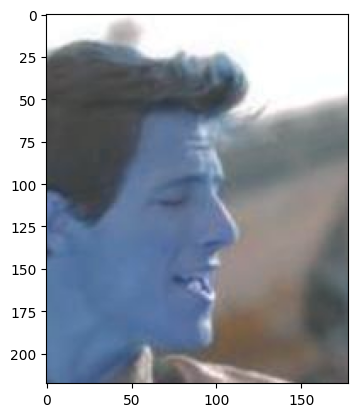

In [411]:
plt.imshow(images[2])

## Loading labels

In [412]:
labels = df_model.head(200)['Male']

In [413]:
labels

0      0
1      0
2      1
3      0
4      0
      ..
195    1
196    1
197    0
198    1
199    1
Name: Male, Length: 200, dtype: int64

## Spliting data

In [429]:
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.2, random_state=42)
labels_train = tf.keras.utils.to_categorical(labels_train)
labels_test = tf.keras.utils.to_categorical(labels_test)


In [430]:
print(len(images_test))
print(len(images_train))
print(len(labels_train))
print(len(labels_test))

40
160
160
40


## Creating img generator

In [431]:
generator = DataGenerator(images=images_train, labels=labels_train, batch_size=16, shuffle=True, augment=True)

In [432]:
val_generator = DataGenerator(images=images_test, labels=labels_test, batch_size=16, shuffle=False, augment=False)

In [433]:
print(val_generator[0][0].shape)

(16, 218, 178, 3)


In [419]:
generator[0]

(array([[[[0.45098039, 0.61176471, 0.78823529],
          [0.44705882, 0.60784314, 0.78431373],
          [0.45098039, 0.61176471, 0.78823529],
          ...,
          [0.78039216, 0.82745098, 0.85490196],
          [0.8       , 0.84705882, 0.87058824],
          [0.80784314, 0.85490196, 0.87843137]],
 
         [[0.45098039, 0.61176471, 0.78823529],
          [0.45098039, 0.61176471, 0.78823529],
          [0.45098039, 0.61176471, 0.78823529],
          ...,
          [0.77254902, 0.82352941, 0.85098039],
          [0.79215686, 0.84313725, 0.86666667],
          [0.80392157, 0.85098039, 0.8745098 ]],
 
         [[0.45098039, 0.60784314, 0.78823529],
          [0.44705882, 0.60784314, 0.78431373],
          [0.45098039, 0.61176471, 0.78823529],
          ...,
          [0.76078431, 0.81568627, 0.84313725],
          [0.78431373, 0.83921569, 0.8627451 ],
          [0.79607843, 0.84705882, 0.87058824]],
 
         ...,
 
         [[0.63529412, 0.70588235, 0.89019608],
          [0.63137

## Checking if generator is working

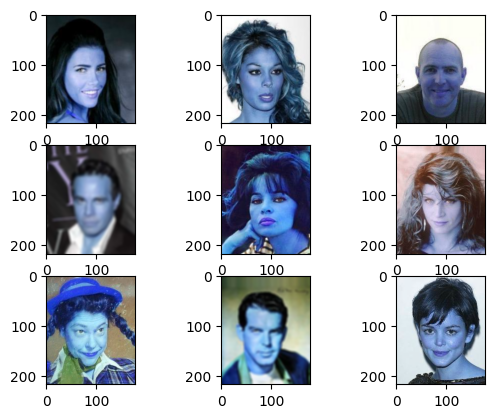

In [434]:
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(generator[0][0][i])

## Creating the model

In [435]:
# Model
model = Sequential()

model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(218, 178, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))

opt = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

## Validating model

In [436]:
history = model.fit(generator, validation_data=val_generator, epochs=5, verbose=True)

Epoch 1/5
10/10 [==============================] - 30s 3s/step - loss: 0.9514 - accuracy: 0.5938 - val_loss: 3.7881 - val_accuracy: 0.4688
Epoch 2/5
10/10 [==============================] - 22s 2s/step - loss: 0.6762 - accuracy: 0.6687 - val_loss: 3.5182 - val_accuracy: 0.4375
Epoch 3/5
10/10 [==============================] - 22s 2s/step - loss: 0.5598 - accuracy: 0.7312 - val_loss: 5.9969 - val_accuracy: 0.4688
Epoch 4/5
10/10 [==============================] - 23s 2s/step - loss: 0.4833 - accuracy: 0.7688 - val_loss: 4.7464 - val_accuracy: 0.4062
Epoch 5/5
10/10 [==============================] - 22s 2s/step - loss: 0.5939 - accuracy: 0.7437 - val_loss: 3.0099 - val_accuracy: 0.4688


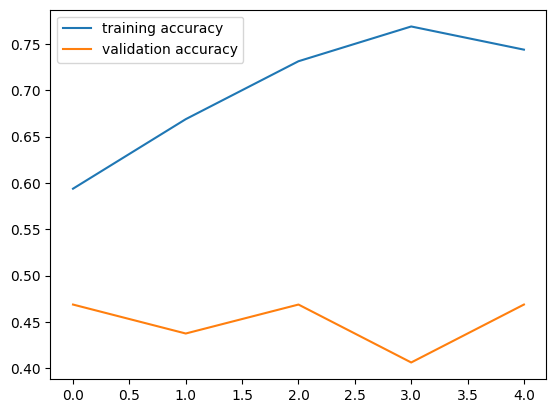

In [438]:
plt.plot(model.history.history["accuracy"], label="training accuracy")
plt.plot(model.history.history["val_accuracy"], label="validation accuracy")
plt.legend()
plt.show()

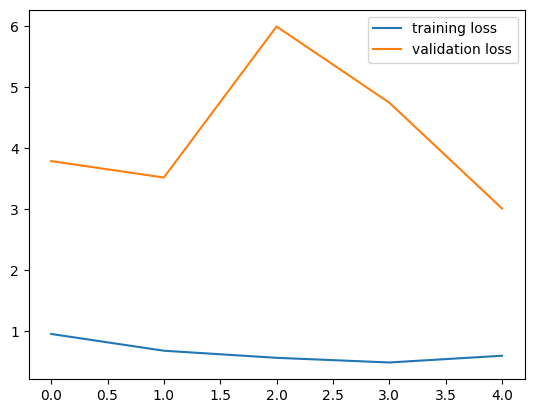

In [439]:
plt.plot(model.history.history["loss"], label="training loss")
plt.plot(model.history.history["val_loss"], label="validation loss")
plt.legend()
plt.show()

In [442]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter( y=history.history['val_loss'], name="val_loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=history.history['loss'], name="loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=history.history['val_accuracy'], name="val accuracy"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter( y=history.history['accuracy'], name="accuracy"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Loss/Accuracy of Sequential Model"
)

# Set x-axis title
fig.update_xaxes(title_text="Epoch")

# Set y-axes titles
fig.update_yaxes(title_text="<b>primary</b> Loss", secondary_y=False)
fig.update_yaxes(title_text="<b>secondary</b> Accuracy", secondary_y=True)

fig.show()

# End of tests

In [237]:
# Wczytanie danych
list_attr_celeba_path = "list_attr_celeba.csv"
list_attr_celeba = pd.read_csv(list_attr_celeba_path)

# Przygotowanie danych
images_path = "img_align_celeba/img_align_celeba"
images = list_attr_celeba["image_id"].head(1000).apply(lambda x: cv2.imread(images_path + x))

# Przetwarzanie etykiet
df_model = df_model.replace(-1, 0)
labels = df_model['Male']
labels_to_model = labels[:1000]

# Podział na zbiór treningowy i testowy
images_train, images_test, labels_train, labels_test = train_test_split(images, labels_to_model, test_size=0.2, random_state=42)


In [238]:
type(images)

pandas.core.series.Series

In [239]:
labels_train = tf.keras.utils.to_categorical(labels_train)
labels_val = tf.keras.utils.to_categorical(labels_test)

generator = DataGenerator(images= images_train, labels=labels_train, batch_size=64, shuffle=True, augment=True)

In [ ]:
print(generator[0])

# Feature engineering

In [ ]:
df_model.drop(['image_id'], axis= 1, inplace=True)
df_model.head()

In [ ]:
df_model.info()

In [ ]:
for column in df_model.columns:

    unique_values = df_model[column].unique()
    print(df_model[column].values)

    print(f"Unique value for column: {column}:")

    print(unique_values)

    print()

In [ ]:
df_model = df_model.replace(-1, 0)

In [ ]:
df_model.describe()

In [ ]:
train_mask = df_model['partition'] == 0
train_mask
# y_val = df_model.pop([df_model['partition'] == 1], ['Male'])
# X_train = df_model[df_model['partition'] == 1]

In [ ]:
train = df_model[train_mask]
train['partition'].describe()

In [ ]:
val_mask = df_model['partition'] == 1
val = df_model[val_mask]
val['partition'].describe()

In [ ]:
y_train = train.pop('Male')
X_train = train

In [ ]:
y_val = val.pop('Male')
X_val = val

In [ ]:
X_val.info()

In [ ]:
X_train.shape

In [ ]:
X_val.shape

In [ ]:
y_train.shape

In [ ]:
# X_train_small = X_train.head(32_550)
# X_val_small = X_val.head(6500)
# y_train_small = y_train.head(32_550)
# y_val_small = y_val.head(6500)

# y_train_small = tf.keras.utils.to_categorical(y_train_small)
# y_val_small = tf.keras.utils.to_categorical(y_val_small)

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)

In [ ]:
y_train

In [ ]:
generator = DataGenerator(images= X_train, labels=y_train, batch_size=64, shuffle=True, augment=True)



In [ ]:
print(generator[0])

In [ ]:
print(generator.labels[0])

In [ ]:
print(type(generator.labels))

In [ ]:
print(type(generator.images[0]))